# LLM Observability for Langchain with Agenta

## Introduction

This guide shows you how to set up tracing for a RAG application in Langchain using Agenta, the open-source LLMOps platform.

Tracing allows us to debug effectively complex LLM applications. It allows us to view exact prompts sent and contexts retrieved. 


We'll build a simple Q&A RAG application that answers questions about Agenta's documentation. Then, we'll instrument the calls (i.e., trace them) and view the trace in Agenta.

This guide uses a Jupyter notebook which you can find here.

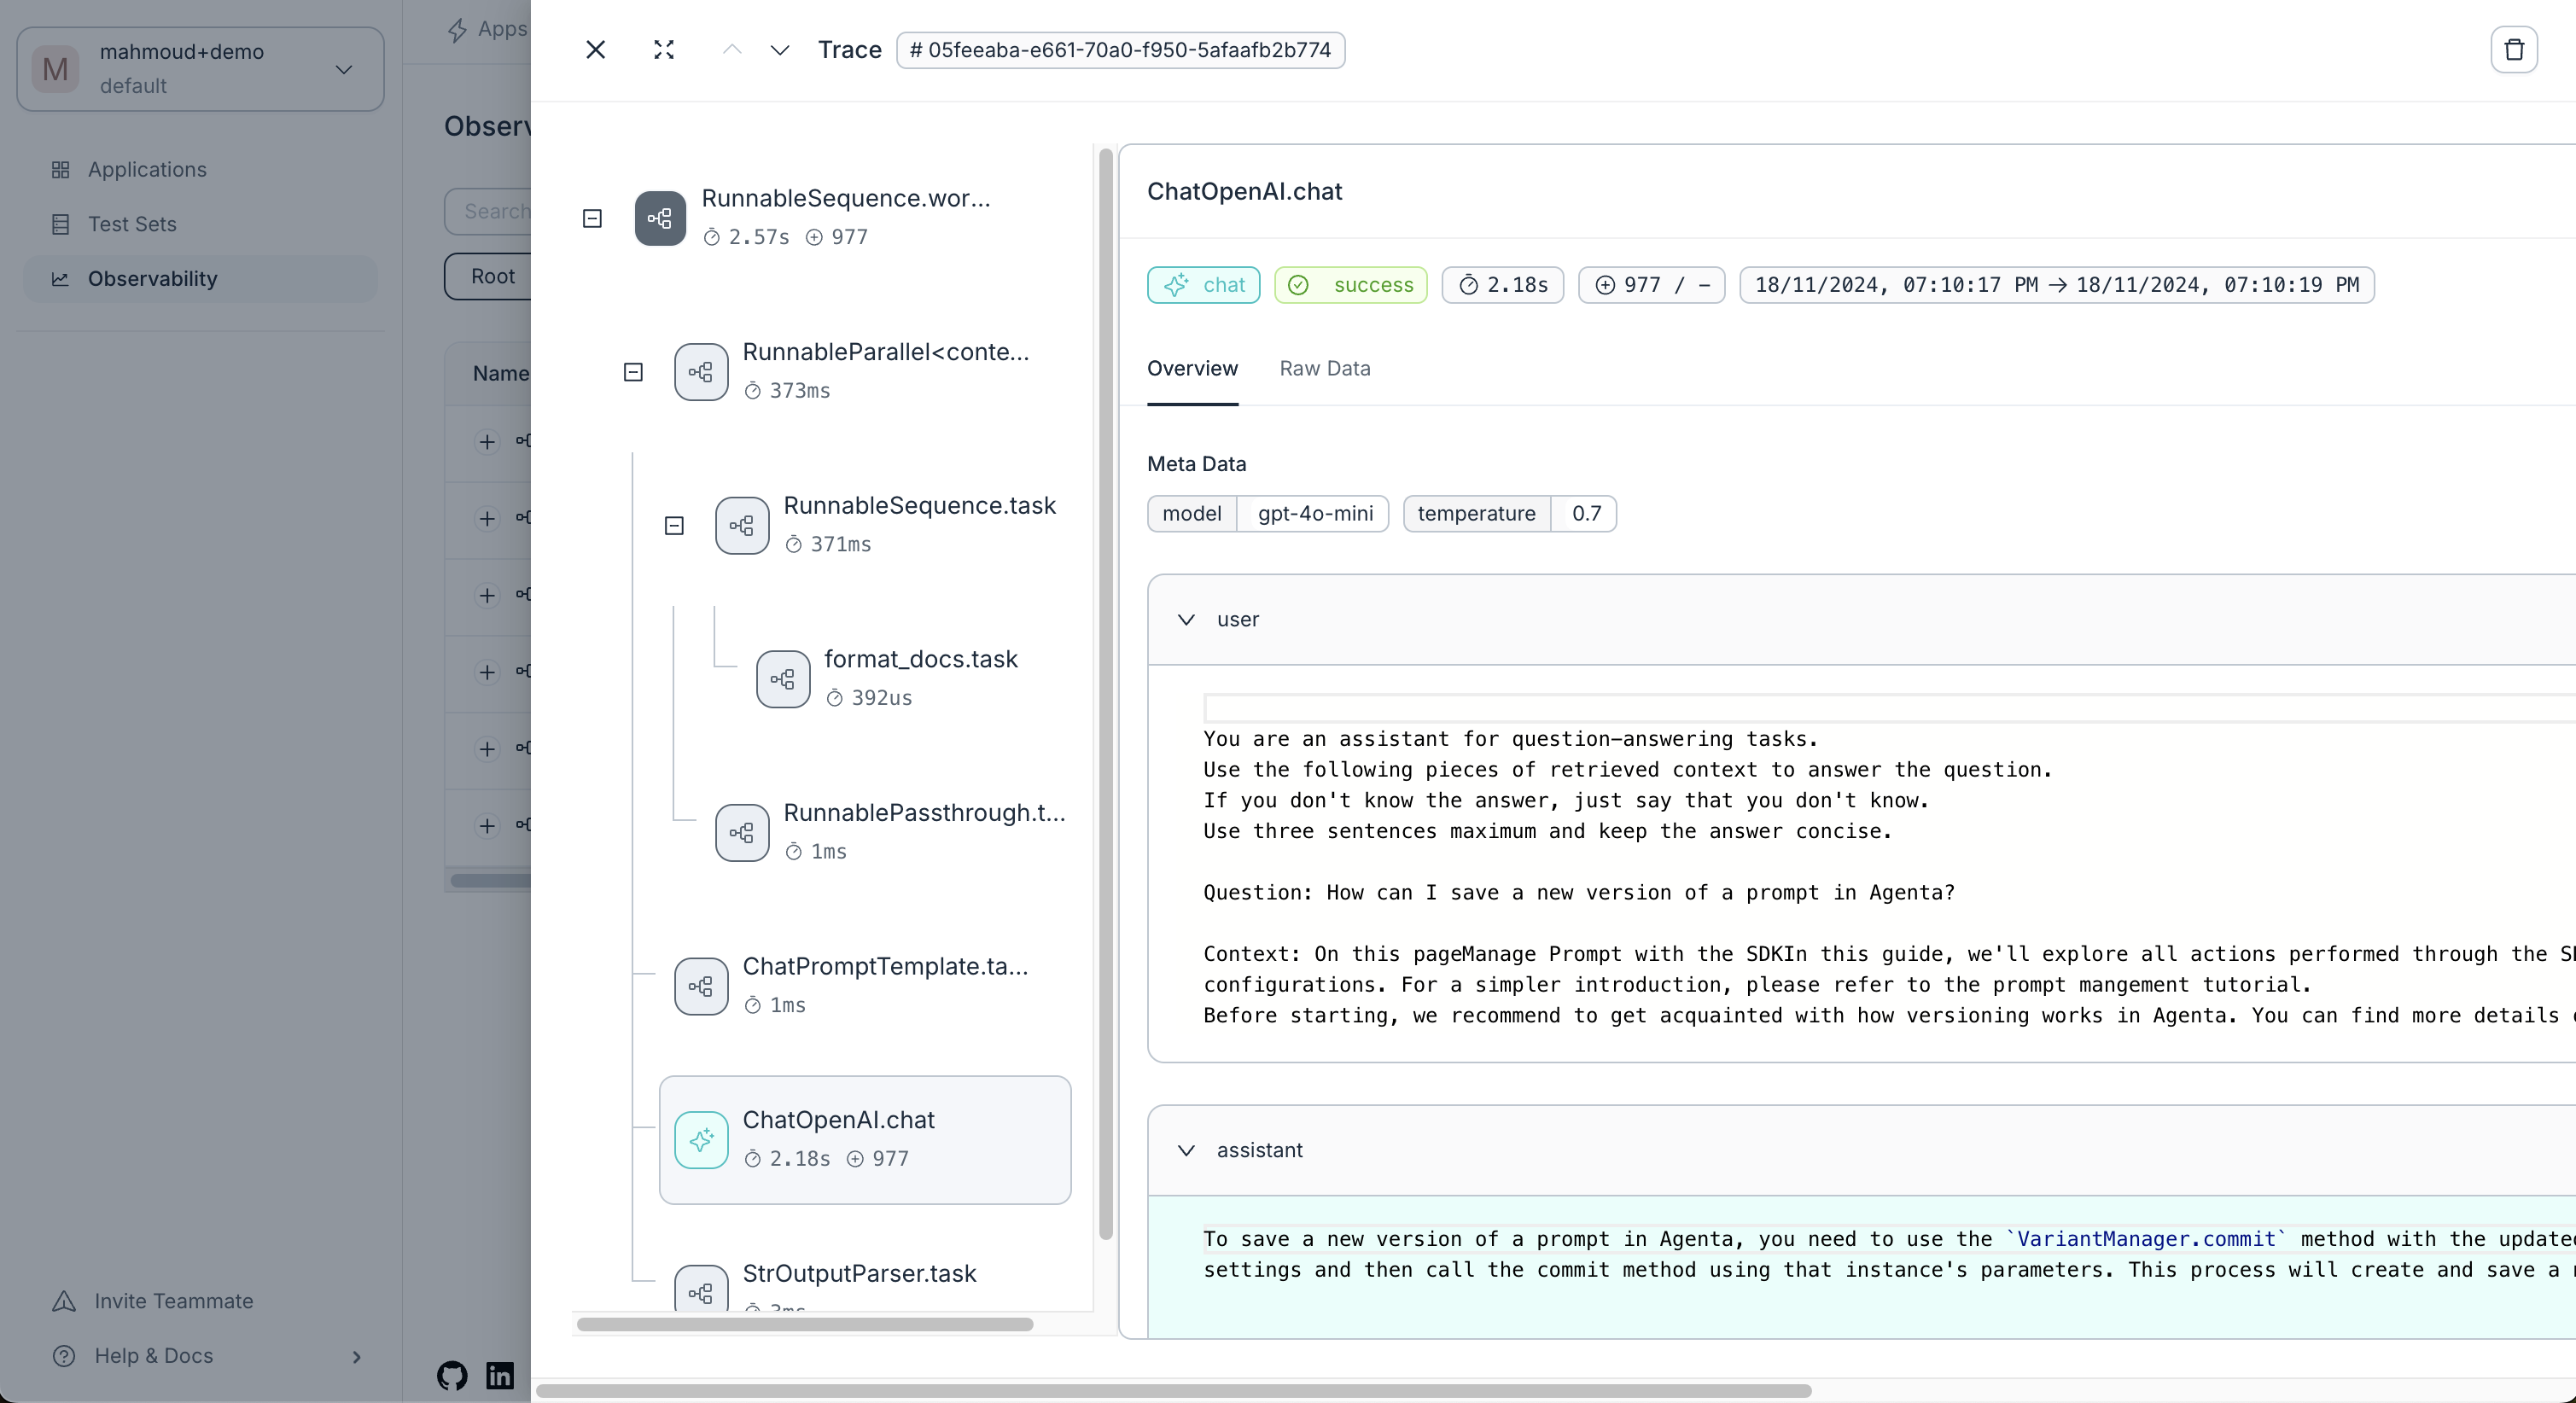

## Setup

First, let's install the langchain, Agenta, and instrumentation dependencies

In [1]:
pip install --quiet agenta langchain langchain_community langchain langchain-chroma langchain-openai opentelemetry-instrumentation-langchain

Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass(prompt="OpenAI API key:") 
# Create an Agenta API key under https://cloud.agenta.ai/settings?tab=apiKeys
os.environ["AGENTA_API_KEY"] = getpass.getpass(prompt="Agenta API key:") 
os.environ["AGENTA_HOST"] = "https://cloud.agenta.ai" # Change for self-hosted


OpenAI API key:········
Agenta API key:········


## Setup tracing

In [7]:
import agenta as ag
from opentelemetry.instrumentation.langchain import LangchainInstrumentor

ag.init()

LangchainInstrumentor().instrument()


---------------------------
Agenta SDK - using version: 0.27.3
---------------------------
--------------------------------------------
Agenta SDK - connecting to otlp receiver at: https://cloud.agenta.ai/api/observability/v1/otlp/traces
--------------------------------------------
Success: traces will be exported.
--------------------------------------------
Overriding of current TracerProvider is not allowed
Attempting to instrument while already instrumented


## The Q&A RAG Application

This Langchain RAG application:

1. Ingests a page from our documentation (chunks and embeds it)
2. Runs the user's query and retrieves relevant context from the page
3. Creates a prompt based on the question and retrieved context, then returns an answer

In [16]:
from langchain_openai import ChatOpenAI


import bs4
from langchain import hub
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts import ChatPromptTemplate

prompt = """
You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Use three sentences maximum and keep the answer concise and to the point.

Question: {question} 

Context: {context} 

Answer:
"""

prompt_template = ChatPromptTemplate([
    ("human", prompt),
])

llm = ChatOpenAI(model="gpt-4o-mini")

loader = WebBaseLoader(
    web_paths=("https://docs.agenta.ai/prompt-management/prompt-management-sdk",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer('article')  # Only parse the core
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())

# Retrieve and generate using the relevant snippets of the blog.
retriever = vectorstore.as_retriever()


rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt_template
    | llm
    | StrOutputParser()
)

rag_chain.invoke("How can I save a new version of a prompt in Agenta?")



'To save a new version of a prompt in Agenta, you need to create a variant, which acts like a branch in git for versioning. After making your changes, commit them to the variant. Finally, you can deploy the specific version of your variant to the desired environment.'